In [3]:
pip install librosA


  Obtaining dependency information for librosA from https://files.pythonhosted.org/packages/74/d4/cd10c82398f3b39bbf60a300e09c931bdf6844f3f2fba9ab2b5981501f9f/librosa-0.10.2-py3-none-any.whl.metadata
  Using cached librosa-0.10.2-py3-none-any.whl.metadata (8.6 kB)
  Obtaining dependency information for audioread>=2.1.9 from https://files.pythonhosted.org/packages/57/8d/30aa32745af16af0a9a650115fbe81bde7c610ed5c21b381fca0196f3a7f/audioread-3.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for soundfile>=0.12.1 from https://files.pythonhosted.org/packages/50/ff/26a4ee48d0b66625a4e4028a055b9f25bc9d7c7b2d17d21a45137621a50d/soundfile-0.12.1-py2.py3-none-win_amd64.whl.metadata
  Obtaining dependency information for soxr>=0.3.2 from https://files.pythonhosted.org/packages/0d/95/8398287a3a00d006ebbe5fcada88bb2536acde2beecce892ff091e1c1a3b/soxr-0.3.7-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/260.0 kB ? eta -:--:--
   - ------------------

## IN THIS FILE WE HAVE INCLUDE SOPME MORE FEATURES AND GENDER AND ACCENT ALSO INCLUDED IN TRAINING THE MODEL

C:\Users\shahg.DESKTOP-BEET8TF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


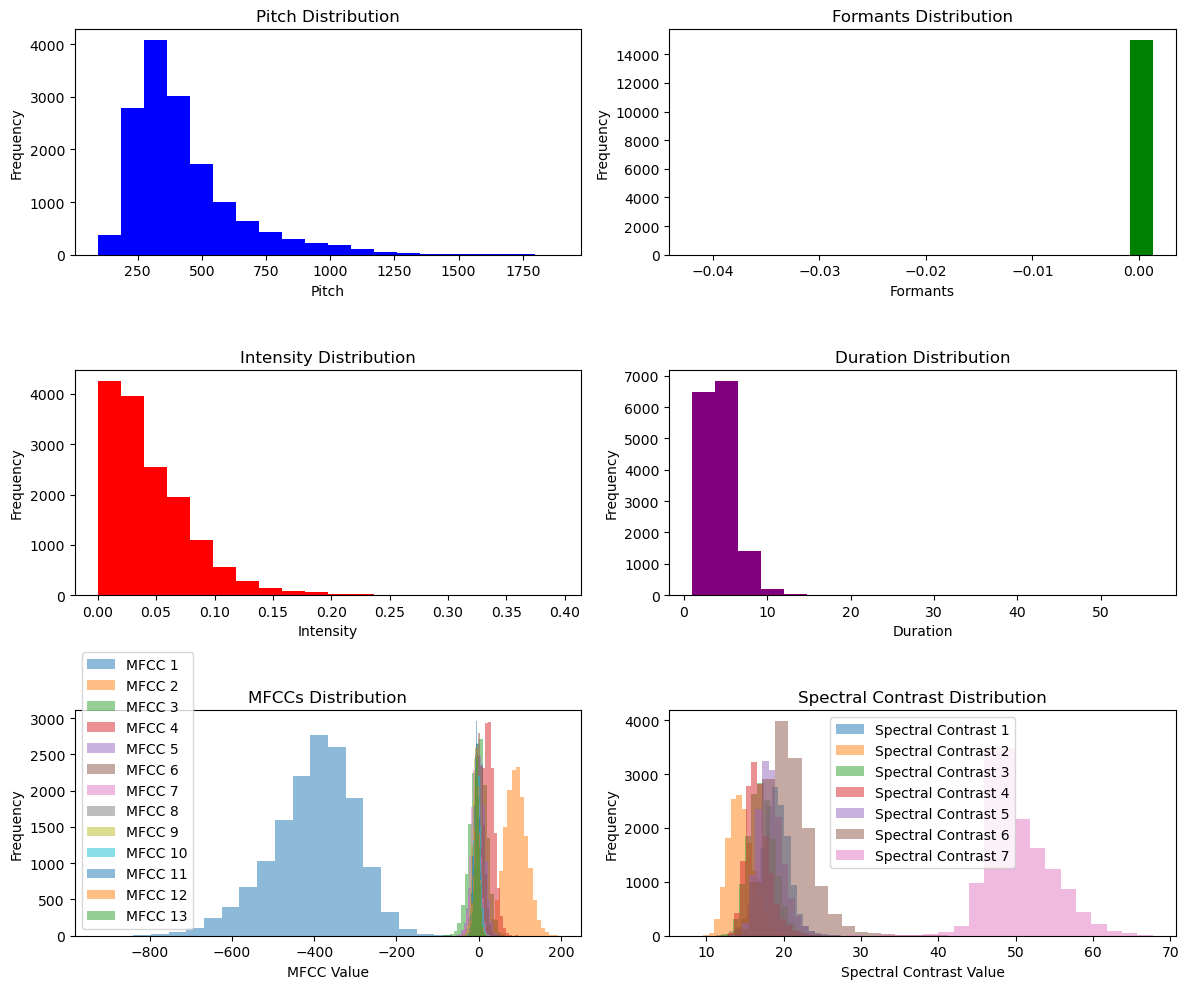

In [2]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the metadata CSV file
metadata = pd.read_csv('truncated_train.csv')

# Function to extract features from audio file
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path)
    
    # Extract features
    pitch = np.mean(librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')))
    formants = np.mean(librosa.effects.harmonic(y))
    intensity = np.mean(np.mean(librosa.feature.rms(y=y)))
    duration = np.mean(librosa.get_duration(y=y, sr=sr))
    # Spectral Features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)  # Extract 13 MFCCs
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    
    return pitch, formants, intensity, duration, mfccs, spectral_contrast

# Iterate through each audio file and extract features
for index, row in metadata.iterrows():
    file_path = row['filename']  # corrected file path
    pitch, formants, intensity, duration, mfccs, spectral_contrast = extract_features(file_path)
    metadata.loc[index, 'pitch'] = pitch
    metadata.loc[index, 'formants'] = formants
    metadata.loc[index, 'intensity'] = intensity
    metadata.loc[index, 'duration'] = duration
    # Store each MFCC value in separate columns
    for i, mfcc_value in enumerate(mfccs):
        metadata.loc[index, f'mfcc_{i+1}'] = mfcc_value
    # Store each spectral contrast value in separate columns
    for i, contrast_value in enumerate(spectral_contrast):
        metadata.loc[index, f'spectral_contrast_{i+1}'] = contrast_value

# Add more audio features relevant for classification and clustering
# Example features: Chroma feature, Zero Crossing Rate, Spectral Roll-off
metadata['chroma'] = metadata['filename'].apply(lambda x: np.mean(librosa.feature.chroma_stft(y=librosa.load(x)[0], sr=librosa.load(x)[1])))
metadata['zero_crossing_rate'] = metadata['filename'].apply(lambda x: np.mean(librosa.feature.zero_crossing_rate(y=librosa.load(x)[0])))
metadata['spectral_rolloff'] = metadata['filename'].apply(lambda x: np.mean(librosa.feature.spectral_rolloff(y=librosa.load(x)[0], sr=librosa.load(x)[1])))

# Clustering using KMeans
features_for_clustering = metadata[['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']]
kmeans = KMeans(n_clusters=5, random_state=42)
metadata['cluster_label'] = kmeans.fit_predict(features_for_clustering)

# Save the updated metadata to a new CSV file
metadata.to_csv('extracted_features_with_clustering.csv', index=False)



# Visualize the extracted features
plt.figure(figsize=(12, 10))

# Pitch Distribution
plt.subplot(3, 2, 1)
plt.hist(metadata['pitch'], bins=20, color='blue')
plt.title('Pitch Distribution')
plt.xlabel('Pitch')
plt.ylabel('Frequency')

# Formants Distribution
plt.subplot(3, 2, 2)
plt.hist(metadata['formants'], bins=20, color='green')
plt.title('Formants Distribution')
plt.xlabel('Formants')
plt.ylabel('Frequency')

# Intensity Distribution
plt.subplot(3, 2, 3)
plt.hist(metadata['intensity'], bins=20, color='red')
plt.title('Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')

# Duration Distribution
plt.subplot(3, 2, 4)
plt.hist(metadata['duration'], bins=20, color='purple')
plt.title('Duration Distribution')
plt.xlabel('Duration')
plt.ylabel('Frequency')

# MFCCs Distribution
plt.subplot(3, 2, 5)
for i in range(1, 14):  # Plotting each MFCC separately
    plt.hist(metadata[f'mfcc_{i}'], bins=20, alpha=0.5, label=f'MFCC {i}')
plt.title('MFCCs Distribution')
plt.xlabel('MFCC Value')
plt.ylabel('Frequency')
plt.legend()

# Spectral Contrast Distribution
plt.subplot(3, 2, 6)
for i in range(7):  # Plotting each spectral contrast separately
    plt.hist(metadata[f'spectral_contrast_{i+1}'], bins=20, alpha=0.5, label=f'Spectral Contrast {i+1}')
plt.title('Spectral Contrast Distribution')
plt.xlabel('Spectral Contrast Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
metadata.head(10)

In [3]:
######################
# Now we have to apply the data preprocessing on the "metadata" DataFrame whic is tord in "extracted features.csv" File 
'''
for data pre processing checking that which columns contains the null values. Any row which contains any null value 
will be dropped . only age gender and accent columns in "extracted features.csv" cntains null values 
'''
rows_with_null_values = metadata[metadata['gender'].isnull()]
rows_with_null_values

,filename,text,up_votes,down_votes,age,gender,accent,duration,pitch,formants,...,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,spectral_contrast_7,chroma,zero_crossing_rate,spectral_rolloff,cluster_label
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,4.104036,276.153616,4.715459e-06,...,16.250239,16.816761,18.308241,20.190508,24.529200,48.265448,0.382842,0.130526,4150.494488,4
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,7.560000,208.362308,-1.470858e-07,...,11.735963,14.716392,14.399232,15.356178,16.662384,46.384036,0.565086,0.230668,6263.453946,3
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,5.064036,441.804795,-4.275901e-06,...,14.966726,19.714124,17.034571,18.967953,21.468176,53.720860,0.358924,0.156393,5609.596064,0
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,6.648027,283.000576,4.910018e-08,...,15.223916,18.491047,15.563766,17.543985,17.763091,45.766907,0.397648,0.151512,4864.102992,1
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,4.896009,272.297389,2.385549e-04,...,18.301381,17.764381,15.996140,18.326108,18.805322,48.433306,0.338093,0.108970,4652.957804,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14990,cv-valid-train/sample-014990.mp3,fatima appeared at the entrance to the tent,2,0,NaN,NaN,NaN,4.608027,698.179497,-3.212382e-05,...,14.871346,16.377670,15.123794,18.064693,18.090232,54.169041,0.397988,0.174554,5117.814782,4
14991,cv-valid-train/sample-014991.mp3,i thought about whether we should find coins a...,8,1,NaN,NaN,NaN,5.184036,433.620651,-6.257302e-07,...,14.936008,16.868583,17.265682,20.375734,20.697561,52.962351,0.405732,0.159239,3724.859619,0
14996,cv-valid-train/sample-014996.mp3,we speak of them only to children,4,0,NaN,NaN,NaN,3.384036,165.601565,-1.305254e-05,...,13.626568,16.958332,16.207756,17.214509,18.460147,59.529596,0.448651,0.113846,3426.139100,0
14997,cv-valid-train/sample-014997.mp3,its been a long time since she last read chekh...,1,0,NaN,NaN,NaN,11.640000,247.735099,-1.149254e-06,...,13.524231,16.090063,15.636896,16.765836,16.910380,46.312268,0.441078,0.141430,5325.178291,0


*I applied scaling using StandardScaler, which includes both centering (mean normalization) and scaling (dividing by standard deviation) in one step. This process effectively normalizes the data by centering it around zero and scaling it to have unit variance. So, normalization is applied along with scaling in the code.*


In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Loading the dataset
dataset = pd.read_csv('extracted_features_with_clustering.csv')

# Droping rows with any null values
cleaned_dataset = dataset.dropna()

# Convert 'gender' and 'accent' to numeric values using LabelEncoder
label_encoder = LabelEncoder()
cleaned_dataset['gender'] = label_encoder.fit_transform(cleaned_dataset['gender'])
cleaned_dataset['accent'] = label_encoder.fit_transform(cleaned_dataset['accent'])

# Separating non-numeric columns because normalization or scaling cannot be applied on string columns
# so they should not be used in scaling and normalization
non_numeric_cols = ['filename', 'text', 'age']

# Separate numeric columns for scaling
numeric_cols = [col for col in cleaned_dataset.columns if col not in non_numeric_cols]

# Normalizing or scale the extracted features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_dataset[numeric_cols])

# Create a DataFrame for scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=numeric_cols)

# Now Add non-numeric columns back to the scaled DataFrame
for col in non_numeric_cols:
    scaled_features_df[col] = cleaned_dataset[col].values

# Saving the preprocessed dataset to a new CSV file
scaled_features_df.to_csv('preprocessed_features.csv', index=False)


C:\Users\shahg.DESKTOP-BEET8TF\AppData\Local\Temp\ipykernel_10488\283440223.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset['gender'] = label_encoder.fit_transform(cleaned_dataset['gender'])
C:\Users\shahg.DESKTOP-BEET8TF\AppData\Local\Temp\ipykernel_10488\283440223.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset['accent'] = label_encoder.fit_transform(cleaned_dataset['accent'])


#### Rearranging the columns 
##### setting the columns ['filename', 'text', 'age', 'gender', 'accent']  at first in my preprocessed_features csv file 

In [5]:
# Loading the preprocessed dataset
preprocessed_data = pd.read_csv('preprocessed_features.csv')
# Separate string columns and numeric columns
string_cols = ['filename', 'text', 'age']
numeric_cols = [col for col in preprocessed_data.columns if col not in string_cols]

# Rearrange columns with string columns first, followed by numeric columns
Final_preprocessed_data = preprocessed_data[string_cols + numeric_cols]

# Save the rearranged dataset to preprocessed_features.csv
Final_preprocessed_data.to_csv('preprocessed_features.csv', index=False)

**now you can check that data is preprocessed like it contain no null values and also normalized all the numeir columns too**

In [6]:
rows_with_null_values = Final_preprocessed_data[Final_preprocessed_data['gender'].isnull()]
rows_with_null_values

,filename,text,age,up_votes,down_votes,gender,accent,duration,pitch,formants,...,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,spectral_contrast_7,chroma,zero_crossing_rate,spectral_rolloff,cluster_label


## NOW EXTRACTING FEATURES AND PREPROCESSING THE CV-VALID-TEST

C:\Users\shahg.DESKTOP-BEET8TF\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
C:\Users\shahg.DESKTOP-BEET8TF\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


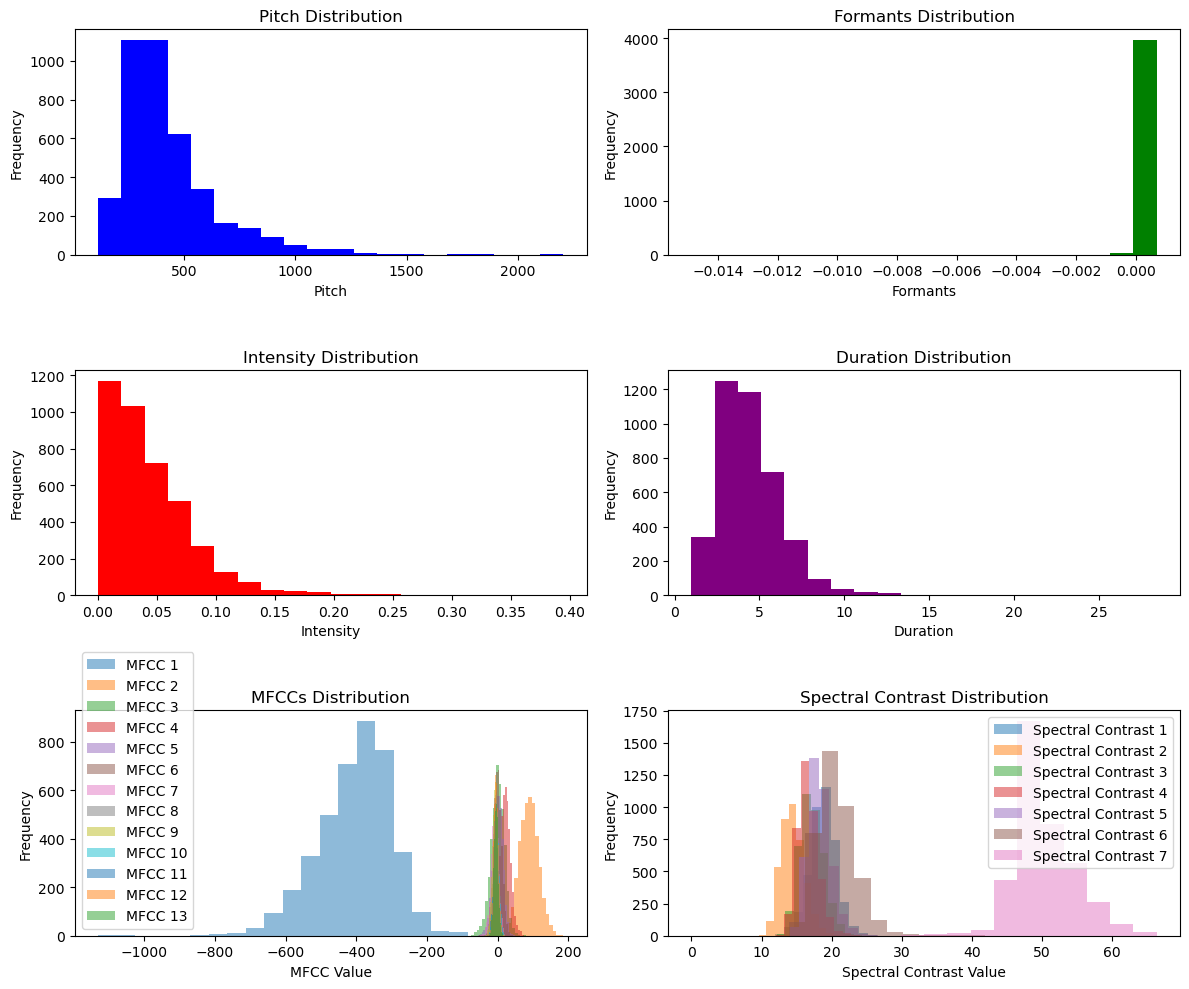

In [7]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the metadata CSV file
metadata = pd.read_csv('cv-valid-test.csv')

# Function to extract features from audio file
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path)
    
    # Extract features
    pitch = np.mean(librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')))
    formants = np.mean(librosa.effects.harmonic(y))
    intensity = np.mean(np.mean(librosa.feature.rms(y=y)))
    duration = np.mean(librosa.get_duration(y=y, sr=sr))
    # Spectral Features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)  # Extract 13 MFCCs
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    
    return pitch, formants, intensity, duration, mfccs, spectral_contrast

# Iterate through each audio file and extract features
for index, row in metadata.iterrows():
    file_path = row['filename']  # corrected file path
    pitch, formants, intensity, duration, mfccs, spectral_contrast = extract_features(file_path)
    metadata.loc[index, 'pitch'] = pitch
    metadata.loc[index, 'formants'] = formants
    metadata.loc[index, 'intensity'] = intensity
    metadata.loc[index, 'duration'] = duration
    # Store each MFCC value in separate columns
    for i, mfcc_value in enumerate(mfccs):
        metadata.loc[index, f'mfcc_{i+1}'] = mfcc_value
    # Store each spectral contrast value in separate columns
    for i, contrast_value in enumerate(spectral_contrast):
        metadata.loc[index, f'spectral_contrast_{i+1}'] = contrast_value

# Add more audio features relevant for classification and clustering
# Example features: Chroma feature, Zero Crossing Rate, Spectral Roll-off
metadata['chroma'] = metadata['filename'].apply(lambda x: np.mean(librosa.feature.chroma_stft(y=librosa.load(x)[0], sr=librosa.load(x)[1])))
metadata['zero_crossing_rate'] = metadata['filename'].apply(lambda x: np.mean(librosa.feature.zero_crossing_rate(y=librosa.load(x)[0])))
metadata['spectral_rolloff'] = metadata['filename'].apply(lambda x: np.mean(librosa.feature.spectral_rolloff(y=librosa.load(x)[0], sr=librosa.load(x)[1])))

# Clustering using KMeans
features_for_clustering = metadata[['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']]
kmeans = KMeans(n_clusters=5, random_state=42)
metadata['cluster_label'] = kmeans.fit_predict(features_for_clustering)

# Save the updated metadata to a new CSV file
metadata.to_csv('TestData_extracted_features_with_clustering.csv', index=False)



# Visualize the extracted features
plt.figure(figsize=(12, 10))

# Pitch Distribution
plt.subplot(3, 2, 1)
plt.hist(metadata['pitch'], bins=20, color='blue')
plt.title('Pitch Distribution')
plt.xlabel('Pitch')
plt.ylabel('Frequency')

# Formants Distribution
plt.subplot(3, 2, 2)
plt.hist(metadata['formants'], bins=20, color='green')
plt.title('Formants Distribution')
plt.xlabel('Formants')
plt.ylabel('Frequency')

# Intensity Distribution
plt.subplot(3, 2, 3)
plt.hist(metadata['intensity'], bins=20, color='red')
plt.title('Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')

# Duration Distribution
plt.subplot(3, 2, 4)
plt.hist(metadata['duration'], bins=20, color='purple')
plt.title('Duration Distribution')
plt.xlabel('Duration')
plt.ylabel('Frequency')

# MFCCs Distribution
plt.subplot(3, 2, 5)
for i in range(1, 14):  # Plotting each MFCC separately
    plt.hist(metadata[f'mfcc_{i}'], bins=20, alpha=0.5, label=f'MFCC {i}')
plt.title('MFCCs Distribution')
plt.xlabel('MFCC Value')
plt.ylabel('Frequency')
plt.legend()

# Spectral Contrast Distribution
plt.subplot(3, 2, 6)
for i in range(7):  # Plotting each spectral contrast separately
    plt.hist(metadata[f'spectral_contrast_{i+1}'], bins=20, alpha=0.5, label=f'Spectral Contrast {i+1}')
plt.title('Spectral Contrast Distribution')
plt.xlabel('Spectral Contrast Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()




In [8]:
metadata.head(10)

,filename,text,up_votes,down_votes,age,gender,accent,duration,pitch,formants,...,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,spectral_contrast_7,chroma,zero_crossing_rate,spectral_rolloff,cluster_label
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,3.216009,459.186503,7.022082e-07,...,13.888250,15.034185,16.025339,18.067680,22.007319,53.028806,0.373245,0.099574,3639.421158,3
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,1.944036,302.496719,1.856417e-05,...,12.100704,16.538164,15.946905,15.298177,21.652879,46.593643,0.466889,0.119501,3830.218506,0
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,1.944036,633.536363,2.329398e-05,...,12.767364,15.118870,14.560524,17.773632,20.490715,50.594906,0.492784,0.219291,5286.401367,0
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,7.704036,337.324202,-1.123706e-06,...,14.953267,17.951357,16.831528,17.424430,18.895103,48.015819,0.383677,0.125718,4618.385627,1
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disablin...,2,0,NaN,NaN,NaN,5.808027,465.323155,1.995911e-06,...,14.968824,21.023572,17.741898,21.108215,20.450829,52.425675,0.373941,0.185880,4997.204444,3
5,cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of pe...,4,1,twenties,male,us,4.656009,253.530632,-4.795695e-06,...,15.297949,18.980604,15.820901,17.908093,23.988722,50.108272,0.363066,0.111629,3717.584320,4
6,cv-valid-test/sample-000006.mp3,strange images passed through my mind,3,0,twenties,male,NaN,4.680000,496.794840,3.228140e-06,...,12.522615,14.843385,14.680533,17.088776,17.269181,48.407815,0.494481,0.197343,5705.072928,1
7,cv-valid-test/sample-000007.mp3,the sheep had taught him that,2,0,thirties,male,NaN,2.616009,398.251319,-1.052385e-06,...,10.916326,13.660045,13.240114,15.791517,16.050822,49.924740,0.575692,0.143010,5225.041266,4
8,cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever...,1,0,thirties,male,england,6.264036,511.494170,-1.791113e-05,...,13.539274,15.315811,16.728349,20.515368,20.934474,61.330732,0.410707,0.188187,4075.876465,3
9,cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky no...,3,0,fifties,male,us,4.440000,460.989017,-5.951669e-07,...,16.413555,18.547269,17.613786,18.636868,23.619434,47.569530,0.356810,0.142321,3596.269226,4


In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Loading the dataset
dataset = pd.read_csv('TestData_extracted_features_with_clustering.csv')

# Droping rows with any null values
cleaned_dataset = dataset.dropna()

# Convert 'gender' and 'accent' to numeric values using LabelEncoder
label_encoder = LabelEncoder()
cleaned_dataset['gender'] = label_encoder.fit_transform(cleaned_dataset['gender'])
cleaned_dataset['accent'] = label_encoder.fit_transform(cleaned_dataset['accent'])

# Separating non-numeric columns because normalization or scaling cannot be applied on string columns
# so they should not be used in scaling and normalization
non_numeric_cols = ['filename', 'text', 'age']

# Separate numeric columns for scaling
numeric_cols = [col for col in cleaned_dataset.columns if col not in non_numeric_cols]

# Normalizing or scale the extracted features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_dataset[numeric_cols])

# Create a DataFrame for scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=numeric_cols)

# Now Add non-numeric columns back to the scaled DataFrame
for col in non_numeric_cols:
    scaled_features_df[col] = cleaned_dataset[col].values

# Saving the preprocessed dataset to a new CSV file
scaled_features_df.to_csv('TestData_preprocessed_features.csv', index=False)


C:\Users\shahg.DESKTOP-BEET8TF\AppData\Local\Temp\ipykernel_10488\1566227953.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset['gender'] = label_encoder.fit_transform(cleaned_dataset['gender'])
C:\Users\shahg.DESKTOP-BEET8TF\AppData\Local\Temp\ipykernel_10488\1566227953.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset['accent'] = label_encoder.fit_transform(cleaned_dataset['accent'])


In [11]:
# Loading the preprocessed dataset
Final_preprocessed_data2 = pd.read_csv('TestData_preprocessed_features.csv')
# Separate string columns and numeric columns
string_cols = ['filename', 'text', 'age']
numeric_cols = [col for col in Final_preprocessed_data2.columns if col not in string_cols]

# Rearrange columns with string columns first, followed by numeric columns
Final_preprocessed_data2 = Final_preprocessed_data2[string_cols + numeric_cols]

# Save the rearranged dataset to preprocessed_features.csv
Final_preprocessed_data2.to_csv('TestData_preprocessed_features.csv', index=False)

### Training dataset

In [12]:
import pandas as pd
import numpy as np



# Preprocess 'age' column
def preprocess_age(age_str):
    if age_str == 'teens':
        return 18
    elif age_str == 'twenties':
        return 24
    elif age_str == 'thirties':
        return 34
    elif age_str == 'fourties':
        return 44
    elif age_str == 'fifties':
        return 54
    elif age_str == 'sixties':
        return 64
    elif age_str == 'seventies':
        return 74
    elif age_str == 'eighties':
        return 84
    elif age_str == 'nineties':
        return 94
    else:
        return 0  # Handle unknown values if any

# Load the preprocessed data
data = pd.read_csv('preprocessed_features.csv')
    
# Apply preprocessing to 'age' column
data['age'] = data['age'].apply(preprocess_age)

data



,filename,text,age,up_votes,down_votes,gender,accent,duration,pitch,formants,...,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,spectral_contrast_7,chroma,zero_crossing_rate,spectral_rolloff,cluster_label
0,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,24,-0.533190,-0.265283,-1.655661,0.973678,0.972002,-0.846260,0.004005,...,0.700635,1.442730,0.311470,0.068749,-0.885663,0.750803,-1.051114,-1.007513,-0.454417,1.046408
1,cv-valid-train/sample-000008.mp3,put jackie right on the staff,74,0.246386,-0.265283,0.538841,0.973678,-1.303392,0.557481,0.009764,...,-1.073389,0.181496,0.896411,0.868430,-0.009648,-0.653410,-0.306944,0.474877,-0.258404,0.336734
2,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,34,-0.533190,-0.265283,-1.655661,0.973678,0.080481,0.033472,-0.002150,...,2.195621,2.524462,1.768148,1.572671,1.451377,0.661809,-1.543822,-0.451182,-1.107444,-1.082613
3,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,64,-0.533190,-0.265283,0.538841,-0.955752,0.719175,-1.124880,-0.030025,...,0.495392,0.897447,0.514847,-0.224700,0.650217,-0.602224,-0.853542,-1.190740,-0.605270,0.336734
4,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,54,-0.533190,-0.265283,0.538841,-1.534581,-0.198974,-0.573117,0.028854,...,-0.720186,-1.831636,-1.150947,-0.962068,-1.420236,-0.599969,2.023787,-1.216190,-0.447386,1.756082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817,cv-valid-train/sample-014993.mp3,but the marketplace was empty and he was far f...,44,-0.533190,-0.265283,0.538841,0.973678,1.876849,-1.070501,0.015529,...,-0.058271,-1.256476,-0.754901,-1.475259,-1.347131,-0.970022,1.017918,-0.698933,0.797480,0.336734
4818,cv-valid-train/sample-014994.mp3,i have already described the appearance of tha...,34,-0.143402,-0.265283,-1.655661,-1.148695,1.451028,-0.375769,0.011069,...,-0.757189,-0.562676,-1.462977,-1.042922,-0.942739,-0.726534,0.237189,0.713359,0.722238,-1.082613
4819,cv-valid-train/sample-014995.mp3,i'm afraid i already know a great many people,34,-0.143402,-0.265283,0.538841,0.973678,-0.584840,-0.615615,0.023223,...,0.137769,0.268944,0.125167,-0.069839,3.651997,-1.390613,0.239800,-0.862110,-1.335882,-1.082613
4820,cv-valid-train/sample-014998.mp3,for at that time it had not occurred to him th...,44,-0.533190,-0.265283,0.538841,0.008963,0.346610,1.123733,0.038586,...,-1.222495,-1.151431,1.094385,1.787651,1.891866,0.304240,-0.294204,1.237959,0.481082,-1.082613


In [13]:
# # Separate features (X) and target variable (y) again
# #SETTING X TO ONLY NUMERUIC COLUMNS 
# X = data.drop(columns=['filename', 'text', 'age', 'gender', 'accent'])
# y = data['age']

# Encode categorical variables (gender, accent) using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['gender', 'accent'])

# Define features and target variable
X = data_encoded.drop(['filename', 'text','age'], axis=1)
y = data_encoded['age']


In [14]:


# Implement linear regression from scratch
class my_LinearRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Initialize weights and bias
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Initialize and train the model
model = my_LinearRegression()
model.fit(X, y)

# Optional: Display coefficients and intercept
print("Coefficients:", model.weights)
print("Intercept:", model.bias)


Coefficients: [-7.88382988e-01 -1.10634372e+00  2.40605044e+00  1.81681333e-01
 -8.00051523e-02  4.34077998e-01 -1.26214741e+00 -2.65918293e+00
  3.45914022e-01 -1.30007654e+00  1.02679634e+00 -2.95416361e-01
  9.33106916e-01  2.93694282e-02 -6.02658024e-01  3.07389458e-03
  1.51315085e+00 -7.21463844e-01  1.08986584e-01  1.21863318e+00
  1.18297068e-01 -8.62039301e-01  1.17693597e+00  9.52795853e-01
 -9.15750509e-01  1.93426962e+00  9.24074154e-01 -6.77985793e-01
 -1.10610255e-01 -3.65169336e-01  1.28608134e+01  1.05353199e+01
  1.71167096e-01  1.20260333e+00  5.66230972e+00 -1.36378552e-01
  3.48590453e+00  6.15186892e+00  2.62554492e-03  5.68233226e-01
  8.20229482e-01 -2.65313800e-01  1.01680461e+00  1.11590745e-01
  2.71148007e+00 -1.61330332e-01  2.63068459e-02  2.08033194e+00
  2.90034143e-01]
Intercept: 23.567300423221788


### NOW TESTING MY MODEL
#### FOR OUT OF EVERY 10 AUDIOS  1 AGE PREDICTION IS EXACT 

In [15]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the preprocessed test data
test_data = pd.read_csv('TestData_preprocessed_features.csv')

# Map age categories to numerical values
age_mapping = {
    'teens': 18, 'twenties': 24, 
    'thirties': 34, 'fourties': 44, 
    'fifties': 54, 'sixties': 64, 'seventies': 74, 
    'eighties': 84, 'nineties': 94
}
test_data['age'] = test_data['age'].map(age_mapping)

test_data

,filename,text,age,up_votes,down_votes,gender,accent,duration,pitch,formants,...,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,spectral_contrast_7,chroma,zero_crossing_rate,spectral_rolloff,cluster_label
0,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,24,0.574853,-0.245667,0.567237,0.981046,2.178421,-0.464397,-0.012698,...,0.367807,0.488312,0.191932,-0.506867,-0.636937,-0.462874,-0.446216,-0.370629,0.209478,-0.604651
1,cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of pe...,24,0.574853,2.006277,0.567237,0.981046,0.320116,-0.870795,-0.212842,...,0.580568,1.078258,-0.475278,-0.208498,1.111470,0.030472,-0.773612,-0.648019,-0.622884,1.175586
2,cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever...,34,-0.491385,-0.245667,0.567237,-0.939720,1.300489,0.380325,-0.927707,...,-0.505007,-1.022336,0.123814,1.399910,0.063086,2.676434,-0.016873,0.859354,-0.291813,0.582174
3,cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky no...,54,0.219440,-0.245667,0.567237,0.981046,0.188421,0.135376,0.016111,...,1.269197,0.829878,0.708374,0.241078,0.984710,-0.568097,-0.872989,-0.043716,-0.734982,1.175586
4,cv-valid-test/sample-000014.mp3,follow the instructions here,24,-0.491385,-0.245667,0.567237,0.404816,-1.113823,-0.291793,0.053071,...,-1.128995,-0.671190,-1.446059,-1.322162,-0.791518,-0.124094,1.754303,-0.232091,0.175903,-1.198064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,cv-valid-test/sample-003971.mp3,he's on my phone,18,-0.491385,-0.245667,0.567237,-0.939720,-0.996782,-0.399120,-0.151668,...,-1.100567,-0.577181,-1.208276,-1.822733,-1.244363,-1.063272,1.906821,1.483014,1.686649,-0.604651
1316,cv-valid-test/sample-003975.mp3,the planet's core is made of solid gold but ev...,24,-0.491385,-0.245667,0.567237,0.981046,1.885777,-0.281511,0.184333,...,0.041563,0.298982,-0.625892,-0.309291,0.175594,-0.984680,-0.346873,-1.009666,-0.903454,1.175586
1317,cv-valid-test/sample-003976.mp3,we've got her located,34,-0.491385,-0.245667,0.567237,-0.939720,-1.406466,-0.607343,-0.228442,...,-0.425570,-0.012385,-0.363948,-0.236678,0.401786,1.249023,0.848374,-0.523128,-0.740604,1.175586
1318,cv-valid-test/sample-003980.mp3,i've got to see nicole right away,54,-0.491385,-0.245667,0.567237,-1.515950,-0.821179,-0.821931,-0.033174,...,0.071871,-2.040433,-1.020744,-1.579295,-0.932966,-0.837692,0.764673,-1.492205,-1.046165,1.175586


In [16]:
# Encode categorical variables (gender, accent) using one-hot encoding
test_data_encoded = pd.get_dummies(test_data, columns=['gender', 'accent'])

# Define features and target variable
X_test = test_data_encoded.drop(['filename', 'text','age'], axis=1)
y_test = test_data_encoded['age']

# # Separate features and target variable
# X_test = test_data.drop(columns=['filename', 'text', 'age', 'gender', 'accent'])
# y_test = test_data['age']

# Use your trained linear regression model to predict ages
y_pred = model.predict(X_test)

# Add the predicted ages to the test data
test_data_encoded['AGE_PREDICTED'] = y_pred

# Save the updated test data to a new CSV file
test_data_encoded.to_csv('TestDatapreprocessed_features_with_predictions.csv', index=False)

test_data_encoded



,filename,text,age,up_votes,down_votes,duration,pitch,formants,intensity,mfcc_1,...,accent_-0.3634904816929228,accent_-0.1714138460505457,accent_0.0206627895918314,accent_0.2127394252342086,accent_0.4048160608765858,accent_0.5968926965189629,accent_0.7889693321613401,accent_0.9810459678037172,accent_1.1731226034460944,AGE_PREDICTED
0,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,24,0.574853,-0.245667,2.178421,-0.464397,-0.012698,-1.002925,-1.556023,...,0,0,0,0,0,0,0,1,0,44.746021
1,cv-valid-test/sample-000005.mp3,down below in the darkness were hundreds of pe...,24,0.574853,2.006277,0.320116,-0.870795,-0.212842,-0.010552,0.443602,...,0,0,0,0,0,0,0,1,0,32.304228
2,cv-valid-test/sample-000008.mp3,this was the strangest of all things that ever...,34,-0.491385,-0.245667,1.300489,0.380325,-0.927707,1.419141,1.418868,...,0,0,0,0,0,0,0,0,0,49.654176
3,cv-valid-test/sample-000009.mp3,it was glaringly hot not a cloud in the sky no...,54,0.219440,-0.245667,0.188421,0.135376,0.016111,-0.311848,0.417693,...,0,0,0,0,0,0,0,1,0,34.369683
4,cv-valid-test/sample-000014.mp3,follow the instructions here,24,-0.491385,-0.245667,-1.113823,-0.291793,0.053071,-0.482823,-0.039279,...,0,0,0,0,1,0,0,0,0,36.435655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,cv-valid-test/sample-003971.mp3,he's on my phone,18,-0.491385,-0.245667,-0.996782,-0.399120,-0.151668,-1.034674,-0.913465,...,0,0,0,0,0,0,0,0,0,40.437489
1316,cv-valid-test/sample-003975.mp3,the planet's core is made of solid gold but ev...,24,-0.491385,-0.245667,1.885777,-0.281511,0.184333,1.145646,0.847175,...,0,0,0,0,0,0,0,1,0,39.785117
1317,cv-valid-test/sample-003976.mp3,we've got her located,34,-0.491385,-0.245667,-1.406466,-0.607343,-0.228442,0.225191,0.346941,...,0,0,0,0,0,0,0,0,0,34.035199
1318,cv-valid-test/sample-003980.mp3,i've got to see nicole right away,54,-0.491385,-0.245667,-0.821179,-0.821931,-0.033174,-0.595366,0.203196,...,0,0,0,0,0,0,0,0,0,33.198226


In [17]:
# Calculate evaluation metrics using numerical ages
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 194.17312201899418
Mean Absolute Error: 11.493373019056099
R-squared: 0.11073972882522898
